# Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# 读取TF 配置, 防止出现BLAS错误

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# 显示变量的位置是否在GPU
tf.debugging.set_log_device_placement(True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
data.shape

(303, 14)

In [9]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

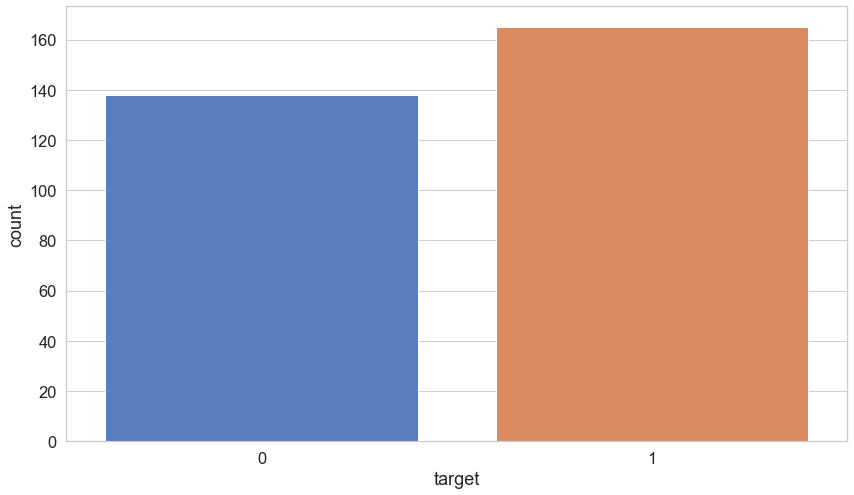

In [12]:
sns.countplot(x='target', data=data)

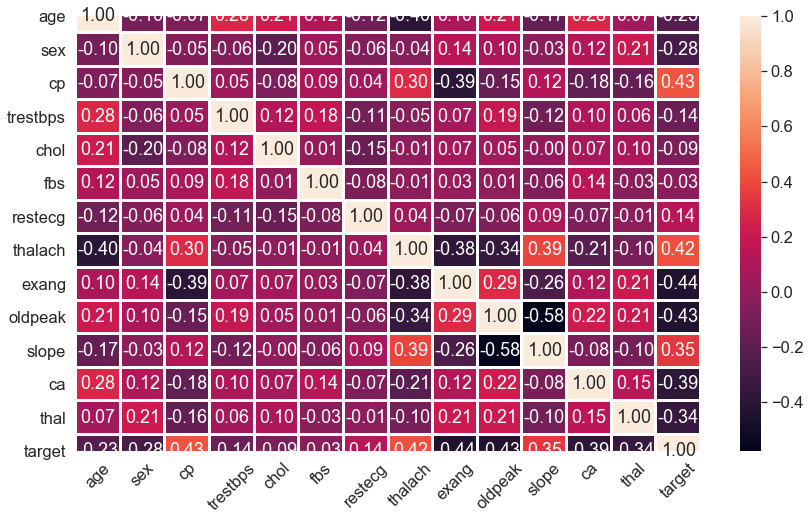

In [17]:
heat_map = sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);

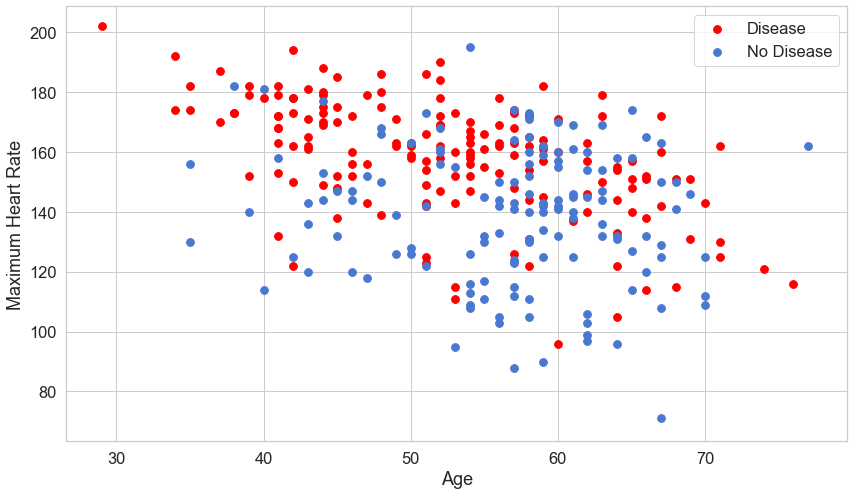

In [18]:
plt.scatter(x=data.age[data.target==1], y=data.thalach[(data.target==1)], c="red", s=60)
plt.scatter(x=data.age[data.target==0], y=data.thalach[(data.target==0)], s=60)
plt.legend(["Disease", "No Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate");

In [19]:
data['Age_Category'] = pd.cut(data['age'],bins=list(np.arange(25, 85, 5)))

Text(0.5, 1.0, 'Age Distribution of Patients with -ve Heart Diagonsis')

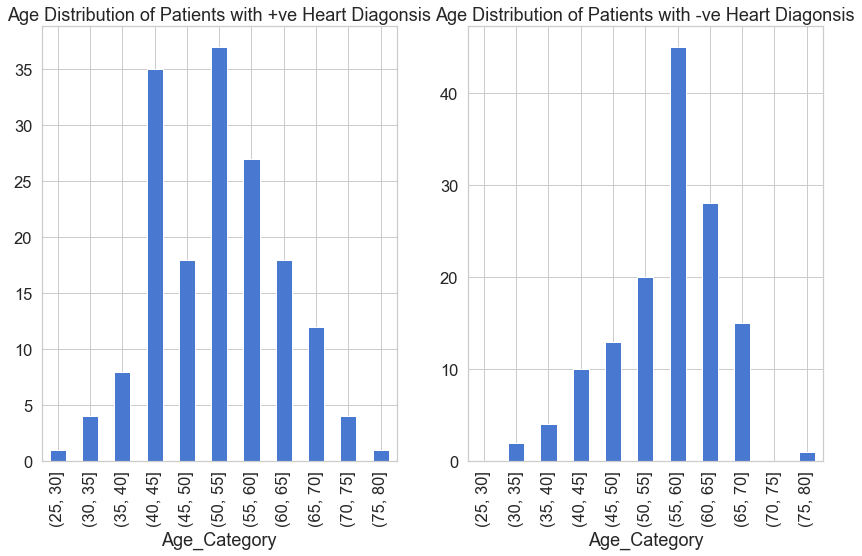

In [20]:
plt.subplot(121)
data[data['target']==1].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients with +ve Heart Diagonsis')

plt.subplot(122)
data[data['target']==0].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients with -ve Heart Diagonsis')

In [21]:
del data['Age_Category']

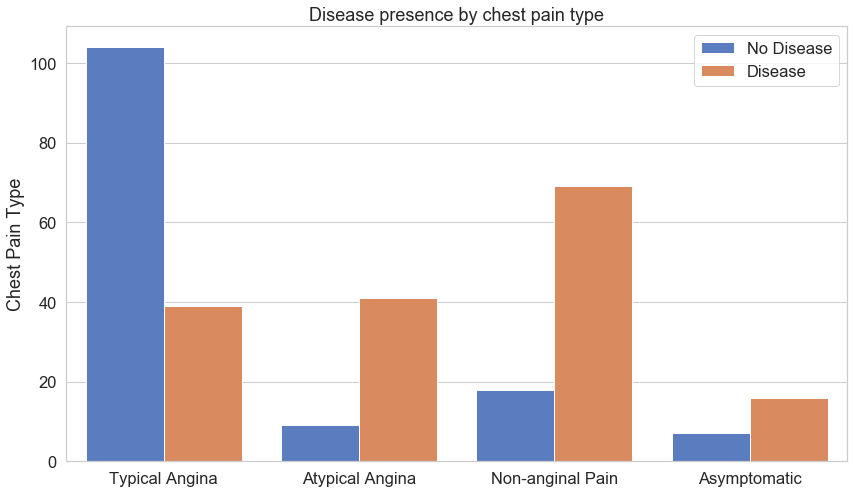

In [22]:
f = sns.countplot(x='cp', data=data, hue='target')
f.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic']);
f.set_title('Disease presence by chest pain type')
plt.ylabel('Chest Pain Type')
plt.xlabel('')
plt.legend(['No Disease', 'Disease']);

In [23]:
X = data.loc[:,data.columns!='target']
y = data.iloc[:,-1]

In [24]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [25]:
feature_columns = []

# numeric cols
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']:
  feature_columns.append(tf.feature_column.numeric_column(header))

# bucketized cols
age = tf.feature_column.numeric_column("age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator cols
data["thal"] = data["thal"].apply(str)
thal = tf.feature_column.categorical_column_with_vocabulary_list(
      'thal', ['3', '6', '7'])
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

data["sex"] = data["sex"].apply(str)
sex = tf.feature_column.categorical_column_with_vocabulary_list(
      'sex', ['0', '1'])
sex_one_hot = tf.feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

data["cp"] = data["cp"].apply(str)
cp = tf.feature_column.categorical_column_with_vocabulary_list(
      'cp', ['0', '1', '2', '3'])
cp_one_hot = tf.feature_column.indicator_column(cp)
feature_columns.append(cp_one_hot)

data["slope"] = data["slope"].apply(str)
slope = tf.feature_column.categorical_column_with_vocabulary_list(
      'slope', ['0', '1', '2'])
slope_one_hot = tf.feature_column.indicator_column(slope)
feature_columns.append(slope_one_hot)


# embedding cols
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed cols
age_thal_crossed = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
age_thal_crossed = tf.feature_column.indicator_column(age_thal_crossed)
feature_columns.append(age_thal_crossed)

cp_slope_crossed = tf.feature_column.crossed_column([cp, slope], hash_bucket_size=1000)
cp_slope_crossed = tf.feature_column.indicator_column(cp_slope_crossed)
feature_columns.append(cp_slope_crossed)

In [27]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [28]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

In [29]:
train_ds = create_dataset(train)
test_ds = create_dataset(test)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [30]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Exe

In [32]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 18ms/step - loss: 0.4396 - accuracy: 0.8361


[0.4395613670349121, 0.8360656]

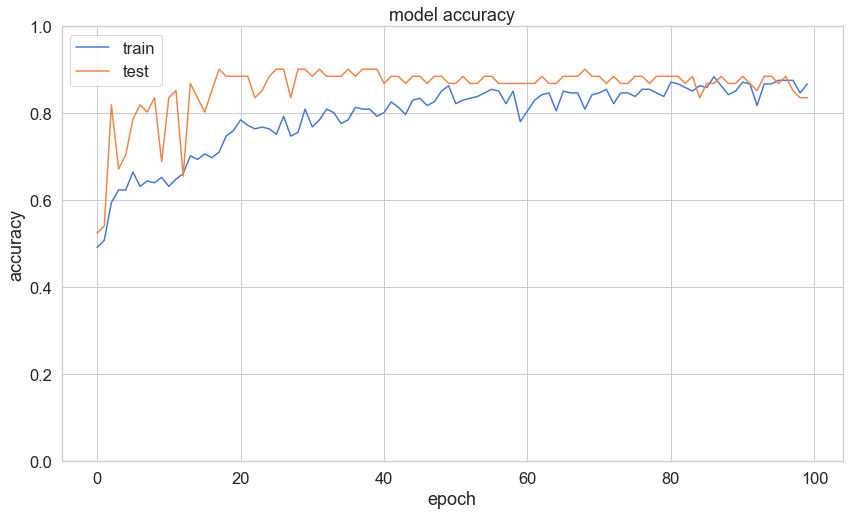

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

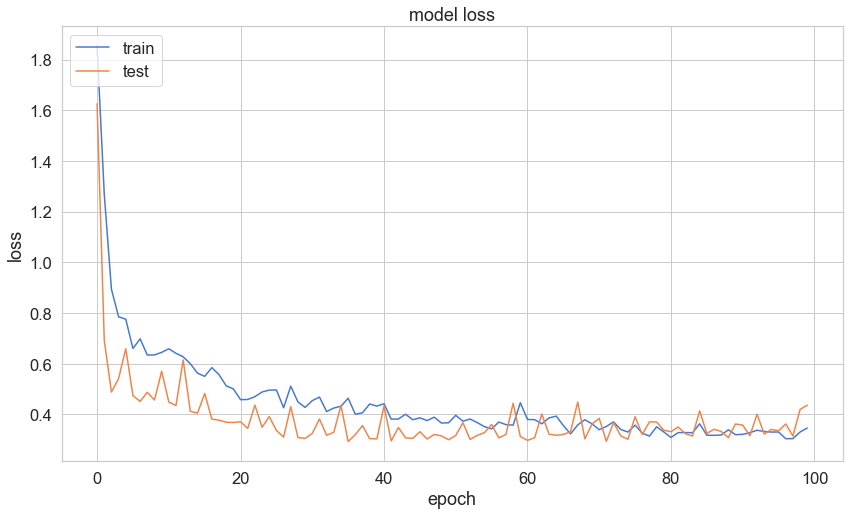

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
predictions = model.predict(test_ds)

Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op HashTableV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_7648 in device /job:localhost/replica:0/task:0/device:GPU:0


In [37]:
bin_predictions = tf.round(predictions).numpy().flatten()

Executing op Round in device /job:localhost/replica:0/task:0/device:GPU:0


In [43]:
print(classification_report(train.values, bin_predictions))

ValueError: Found input variables with inconsistent numbers of samples: [242, 61]